## Parameter estimation setup
This example goes through the steps of setting up the parameter estimation task directly from basiCO. Experimental data is provided through pandas dataframes, and mapping of the columns will be done by convention using specially crafted column names. 

We start as usual: 

In [1]:
import sys
if '../..' not in sys.path:
    sys.path.append('../..')
from basico import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### preparing the data
In this example we generate the data set by modifying the brusselator model, to produce some noisy data, and we will take that data set as a starting point for the parameter estimation later on. So lets start loading the brusselator model, and adding two observable variables that follow the model species with some noise added: 

In [2]:
load_example('brusselator')
add_parameter('obs_x', type='assignment', expression='[X] + UNIFORM(0,1) - 0.5')
add_parameter('obs_y', type='assignment', expression='[Y] + UNIFORM(0,1) - 0.5');

now we simulate the model, ensuring to return all result columns (not just the concentration ones)

In [3]:
result = run_time_course(start_time=0, use_number=True)

In [4]:
result.head()

,X,Y,Values[obs_x],Values[obs_y]
Time,,,,
0.0,2.999996,2.999996,2.795629,3.114868
0.5,3.408155,0.817484,3.086833,1.012499
1.0,1.896454,1.276790,1.456064,1.714168
1.5,0.876253,1.872929,0.579525,2.232427
2.0,0.345934,2.368188,0.448776,2.465324


lets plot the simulation data (first plot) and the noisy data (second plot)

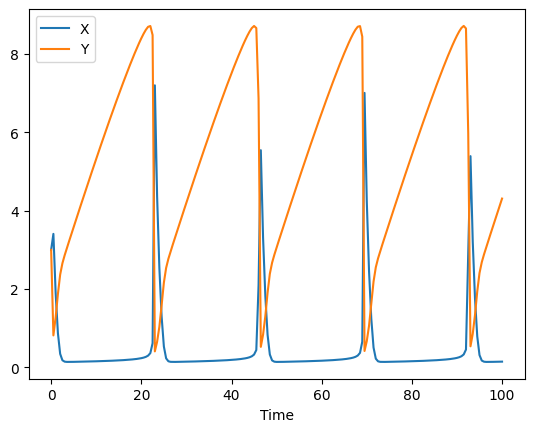

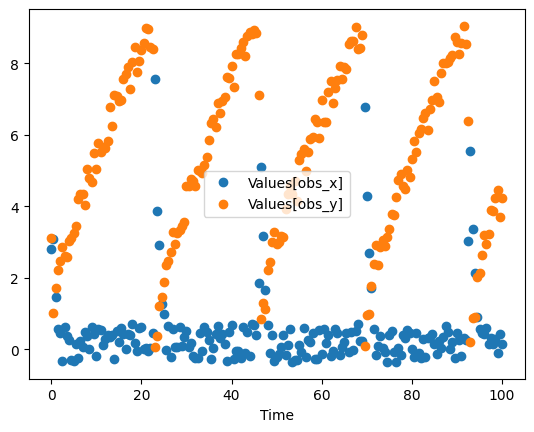

In [5]:
ax = result.plot(y='X')
result.plot(y='Y', ax=ax)

ax = result.plot(y='Values[obs_x]', style='o')
result.plot(y='Values[obs_y]', style='o' , ax=ax);


so our experimental data is the data frame with just the 2 last columns. I also rename the columns, so it makes it clear that i want to map it later to the transient concentrations. I'll also reset the index, so Time is a separate column: 

In [6]:
data = result.drop(columns=['X', 'Y'])
data.rename(columns = {'Values[obs_x]':'[X]', 'Values[obs_y]':'[Y]'}, inplace=True)
data = data.reset_index()

In [7]:
data.head()

,Time,[X],[Y]
0,0.0,2.795629,3.114868
1,0.5,3.086833,1.012499
2,1.0,1.456064,1.714168
3,1.5,0.579525,2.232427
4,2.0,0.448776,2.465324


the parameters that gave rise to the solution were: 

In [8]:
get_reaction_parameters()

,value,reaction,type,mapped_to
name,,,,
(R1).k1,1.0,R1,local,
(R2).k1,1.0,R2,local,
(R3).k1,1.0,R3,local,
(R4).k1,1.0,R4,local,


lets set them to something, else, so that the parameter estimation task will have something to do to find them again (we also remove the observable variables as we won't need them anymore): 

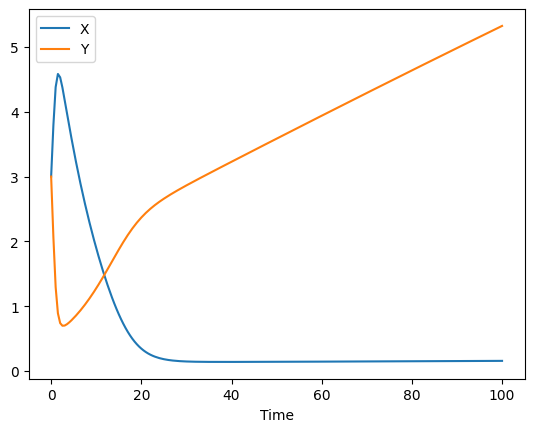

In [9]:
set_reaction_parameters(['(R1).k1', '(R2).k1', '(R3).k1', '(R4).k1'], value=0.1)
remove_parameter('obs_x')
remove_parameter('obs_y')
run_time_course(start_time=0).plot();

In [10]:
get_reaction_parameters()

,value,reaction,type,mapped_to
name,,,,
(R1).k1,0.1,R1,local,
(R2).k1,0.1,R2,local,
(R3).k1,0.1,R3,local,
(R4).k1,0.1,R4,local,


### setting up the parameter estimation
the next step is to setup the paramter estimation task, first we add the experiment, and it will tell us where the experiment file has been created in case you want to delete it later. 

In [11]:
add_experiment('exp1', data)

'/Users/frank/Development/basico/docs/notebooks/exp1.txt'

now lets verify that the experiment is there: 

In [12]:
get_experiment('exp1')

<CExperiment "exp1">

and we have the mapping we were expecting: 

In [13]:
get_experiment_mapping('exp1')

,type,mapping,cn,column_name
column,,,,
0,time,,,Time
1,dependent,[X],"CN=Root,Model=The Brusselator,Vector=Compartme...",[X]
2,dependent,[Y],"CN=Root,Model=The Brusselator,Vector=Compartme...",[Y]


now we are ready to add the parameters we want to fit, in our case this will be the reaction parameters: 

In [14]:
fit_items = [
            {'name': '(R1).k1', 'lower': 0.001, 'upper': 2},
            {'name': '(R2).k1', 'lower': 0.001, 'upper': 2},
            {'name': '(R3).k1', 'lower': 0.001, 'upper': 2},
            {'name': '(R4).k1', 'lower': 0.001, 'upper': 2},
        ]

In [15]:
set_fit_parameters(fit_items)

In [16]:
get_fit_parameters()

,lower,upper,start,affected,cn
name,,,,,
(R1).k1,0.001,2,0.1,[],"CN=Root,Model=The Brusselator,Vector=Reactions..."
(R2).k1,0.001,2,0.1,[],"CN=Root,Model=The Brusselator,Vector=Reactions..."
(R3).k1,0.001,2,0.1,[],"CN=Root,Model=The Brusselator,Vector=Reactions..."
(R4).k1,0.001,2,0.1,[],"CN=Root,Model=The Brusselator,Vector=Reactions..."


and with that we are ready to run the parameter estimation. Lets see how the fit looks now, it should be bad, since we set the parameters way off: 

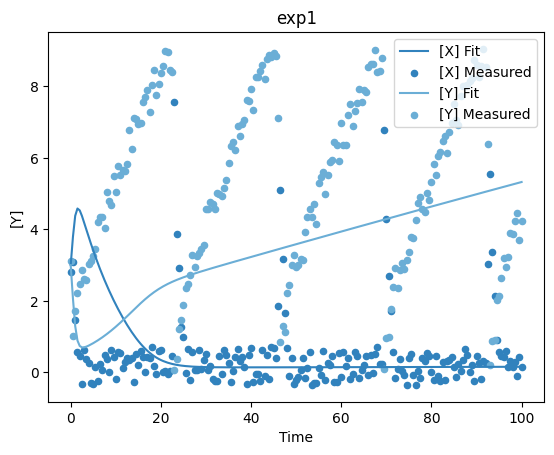

In [17]:
plot_per_experiment();

Now lets run the parameter estimation, all the task names from the COPASI GUI are valid, algorithms here: 

Current Solution:

* `Current Solution Statistics`,

Global Methods: 

* `Random Search`,
* `Simulated Annealing`,
* `Differential Evolution`,
* `Scatter Search`,
* `Genetic Algorithm`,
* `Evolutionary Programming`,
* `Genetic Algorithm SR`,
* `Evolution Strategy (SRES)`,
* `Particle Swarm`,

Local Methods:

* `Levenberg - Marquardt`,
* `Hooke & Jeeves`,
* `Nelder - Mead`,
* `Steepest Descent`,
* `NL2SOL`,
* `Praxis`,
* `Truncated Newton`,


In [18]:
run_parameter_estimation(method='Evolution Strategy (SRES)', update_model=True)

,lower,upper,sol,affected
name,,,,
(R1).k1,0.001,2,0.908366,[]
(R2).k1,0.001,2,0.001000,[]
(R3).k1,0.001,2,0.025244,[]
(R4).k1,0.001,2,0.902824,[]


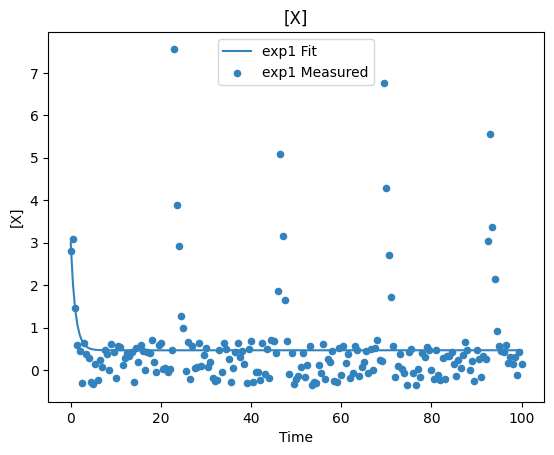

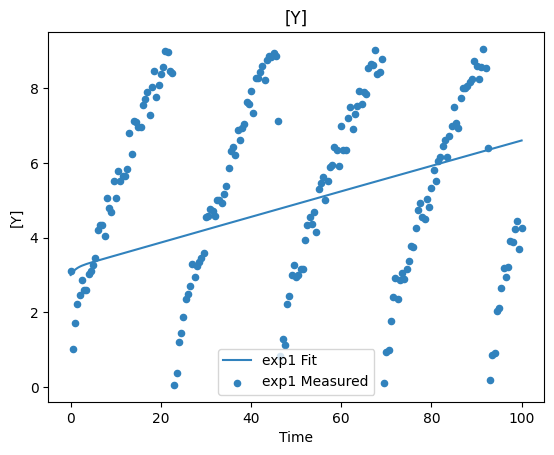

In [19]:
plot_per_dependent_variable();

### Constraints
Additionally, you can add constraints to the parameter estimation problem. These constraint will be evaluated after each simulation, and allow to ensure, for example that solutions with concentrations outside a certain range are rejected. 

Constraints are defined, just as the fit parameters specified above, when using `set_fit_constraints`. To see the constraints defined, you would use `get_fit_constraints`. 

To demonstrate, lets create a constraint for this example, that rejects solutions, where the concentration of `[Y]` is outside the range of 2...10.

In [20]:
set_fit_constraints([
    {'name': 'Y', 'lower': 2, 'upper': 10}
])

`get_fit_constraints` returns a pandas dataframe of the constraints, and as usual we can trasnform them to a dictionary if needed using `as_dict`.

In [21]:
get_fit_constraints()

,lower,upper,start,affected,cn
name,,,,,
Y,2,10,6.597017,[],"CN=Root,Model=The Brusselator,Vector=Compartme..."


In [22]:
as_dict(get_fit_constraints())

{'name': 'Y',
 'lower': '2',
 'upper': '10',
 'start': 6.597017117106328,
 'affected': [],
 'cn': CN=Root,Model=The Brusselator,Vector=Compartments[compartment],Vector=Metabolites[Y],Reference=Concentration}

now lets try to run the parameter estimation again, using this constraint: 

In [23]:
run_parameter_estimation(method=PE.LEVENBERG_MARQUARDT)
get_fit_statistic()

{'obj': 295.53087769380215,
 'rms': 0.8574097253059701,
 'sd': 0.8617075453441385,
 'f_evals': 147,
 'failed_evals_exception': 0,
 'failed_evals_nan': 0,
 'constraint_evals': 2,
 'failed_constraint_evals': 0,
 'cpu_time': 0.028593999999999998,
 'data_points': 402,
 'valid_data_points': 402,
 'evals_per_sec': 0.00019451700680272107}

If we look at the fit statistic, we see that the evalations failed. This happened, because the allowed interval in the constraint was too small. Setting the lower bound of the constraint, fixes that issue: 

In [24]:
set_fit_constraints([
    {'name': 'Y', 'lower': 0, 'upper': 10}
])
run_parameter_estimation(method=PE.LEVENBERG_MARQUARDT)
get_fit_statistic()

{'obj': 295.53087769380215,
 'rms': 0.8574097253059701,
 'sd': 0.8617075453441385,
 'f_evals': 147,
 'failed_evals_exception': 0,
 'failed_evals_nan': 0,
 'constraint_evals': 2,
 'failed_constraint_evals': 0,
 'cpu_time': 0.026792,
 'data_points': 402,
 'valid_data_points': 402,
 'evals_per_sec': 0.00018225850340136056}

We've seen how to add constraints to the parameter estimation problem, and how it would look if the constraint causes the parameter estimation procedure to fail. 